# Logit Evolution: Statistical Analysis

**How do logits evolve during training?**

Starting hypothesis: All logits identical → model learns → logits spread out

## Metrics

1. **Entropy:** H = -Σ p·log(p) - measures uncertainty
2. **Spread:** max - min - measures range
3. **Confidence:** max - mean(others) - how much top choice stands out
4. **Gini coefficient:** inequality measure (0=uniform, 1=concentrated)
5. **Top-k probability mass:** sum of top k probabilities
6. **Unique values:** number of distinct logit values
7. **Std deviation:** dispersion measure

## Parameters

In [37]:
# Data source - change this to analyze different runs
TRAINING_DATA_PATH = '../tensors/Lil_Gatsby/1.9d_training_data.safetensors'
RUN_NAME = '1.9d (SGD, lr=1e-1, batch=1)'

# Analysis
SAMPLE_EVERY_N = 1  # Analyze every Nth step (1 = all steps)
TOP_K_VALUES = [1, 5, 10, 20]  # Top-k to analyze

# Visualization
DPI = 200
COLORMAP = 'inferno'

## Imports

In [38]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from scipy.special import softmax

## Load Data

In [39]:
data = load_file(TRAINING_DATA_PATH)
logits = data['logits'].cpu().numpy()  # (n_steps, 128)

print(f'Loaded: {RUN_NAME}')
print(f'Logits shape: {logits.shape}')
print(f'Steps: {logits.shape[0] - 1} (plus initial)')
print(f'Vocab size: {logits.shape[1]}')

Loaded: 1.9d (SGD, lr=1e-1, batch=1)
Logits shape: (1001, 128)
Steps: 1000 (plus initial)
Vocab size: 128


## Compute Statistics

In [40]:
print('Computing statistics...')
print()

# Sample steps
step_indices = np.arange(0, logits.shape[0], SAMPLE_EVERY_N)
n_steps = len(step_indices)

# Storage
stats = {
    'steps': step_indices,
    'entropy': np.zeros(n_steps),
    'spread': np.zeros(n_steps),
    'confidence': np.zeros(n_steps),
    'gini': np.zeros(n_steps),
    'std': np.zeros(n_steps),
    'n_unique': np.zeros(n_steps, dtype=int),
}

# Top-k probability mass
for k in TOP_K_VALUES:
    stats[f'top_{k}_prob'] = np.zeros(n_steps)

# Compute per step
for i, step_idx in enumerate(step_indices):
    logit_vec = logits[step_idx]
    
    # Convert to probabilities
    probs = softmax(logit_vec)
    
    # 1. Entropy
    # Avoid log(0) by adding small epsilon
    probs_safe = np.clip(probs, 1e-10, 1.0)
    entropy = -np.sum(probs_safe * np.log2(probs_safe))
    stats['entropy'][i] = entropy
    
    # 2. Spread
    spread = logit_vec.max() - logit_vec.min()
    stats['spread'][i] = spread
    
    # 3. Confidence (max vs mean of others)
    max_logit = logit_vec.max()
    max_idx = logit_vec.argmax()
    others = np.delete(logit_vec, max_idx)
    confidence = max_logit - others.mean()
    stats['confidence'][i] = confidence
    
    # 4. Gini coefficient (on probabilities)
    sorted_probs = np.sort(probs)
    n = len(sorted_probs)
    index = np.arange(1, n + 1)
    gini = (2 * np.sum(index * sorted_probs)) / (n * np.sum(sorted_probs)) - (n + 1) / n
    stats['gini'][i] = gini
    
    # 5. Std
    stats['std'][i] = logit_vec.std()
    
    # 6. Unique values
    stats['n_unique'][i] = len(np.unique(logit_vec))
    
    # 7. Top-k probability mass
    sorted_probs_desc = np.sort(probs)[::-1]
    for k in TOP_K_VALUES:
        stats[f'top_{k}_prob'][i] = sorted_probs_desc[:k].sum()

print(f'✓ Computed statistics for {n_steps} steps')

Computing statistics...

✓ Computed statistics for 1001 steps


## Summary Statistics

In [41]:
print('='*70)
print('LOGIT EVOLUTION SUMMARY')
print('='*70)
print()
print(f'Run: {RUN_NAME}')
print(f'Steps analyzed: {n_steps}')
print()

# Show initial vs final
print('Initial state (step 0):')
print(f'  Entropy: {stats["entropy"][0]:.4f} bits (max = {np.log2(128):.4f})')
print(f'  Spread: {stats["spread"][0]:.4f}')
print(f'  Confidence: {stats["confidence"][0]:.4f}')
print(f'  Gini: {stats["gini"][0]:.4f} (0=uniform, 1=concentrated)')
print(f'  Unique values: {stats["n_unique"][0]}')
print()

print(f'Final state (step {step_indices[-1]}):')
print(f'  Entropy: {stats["entropy"][-1]:.4f} bits')
print(f'  Spread: {stats["spread"][-1]:.4f}')
print(f'  Confidence: {stats["confidence"][-1]:.4f}')
print(f'  Gini: {stats["gini"][-1]:.4f}')
print(f'  Unique values: {stats["n_unique"][-1]}')
print()

# Changes
print('Changes (final - initial):')
print(f'  Δ Entropy: {stats["entropy"][-1] - stats["entropy"][0]:+.4f} bits')
print(f'  Δ Spread: {stats["spread"][-1] - stats["spread"][0]:+.4f}')
print(f'  Δ Confidence: {stats["confidence"][-1] - stats["confidence"][0]:+.4f}')
print(f'  Δ Gini: {stats["gini"][-1] - stats["gini"][0]:+.4f}')
print()
print('='*70)

LOGIT EVOLUTION SUMMARY

Run: 1.9d (SGD, lr=1e-1, batch=1)
Steps analyzed: 1001

Initial state (step 0):
  Entropy: 7.0000 bits (max = 7.0000)
  Spread: 0.0000
  Confidence: 0.0000
  Gini: 0.0000 (0=uniform, 1=concentrated)
  Unique values: 1

Final state (step 1000):
  Entropy: 4.3667 bits
  Spread: 8.4375
  Confidence: 6.5113
  Gini: 0.8776
  Unique values: 46

Changes (final - initial):
  Δ Entropy: -2.6333 bits
  Δ Spread: +8.4375
  Δ Confidence: +6.5113
  Δ Gini: +0.8776



## Entropy Evolution

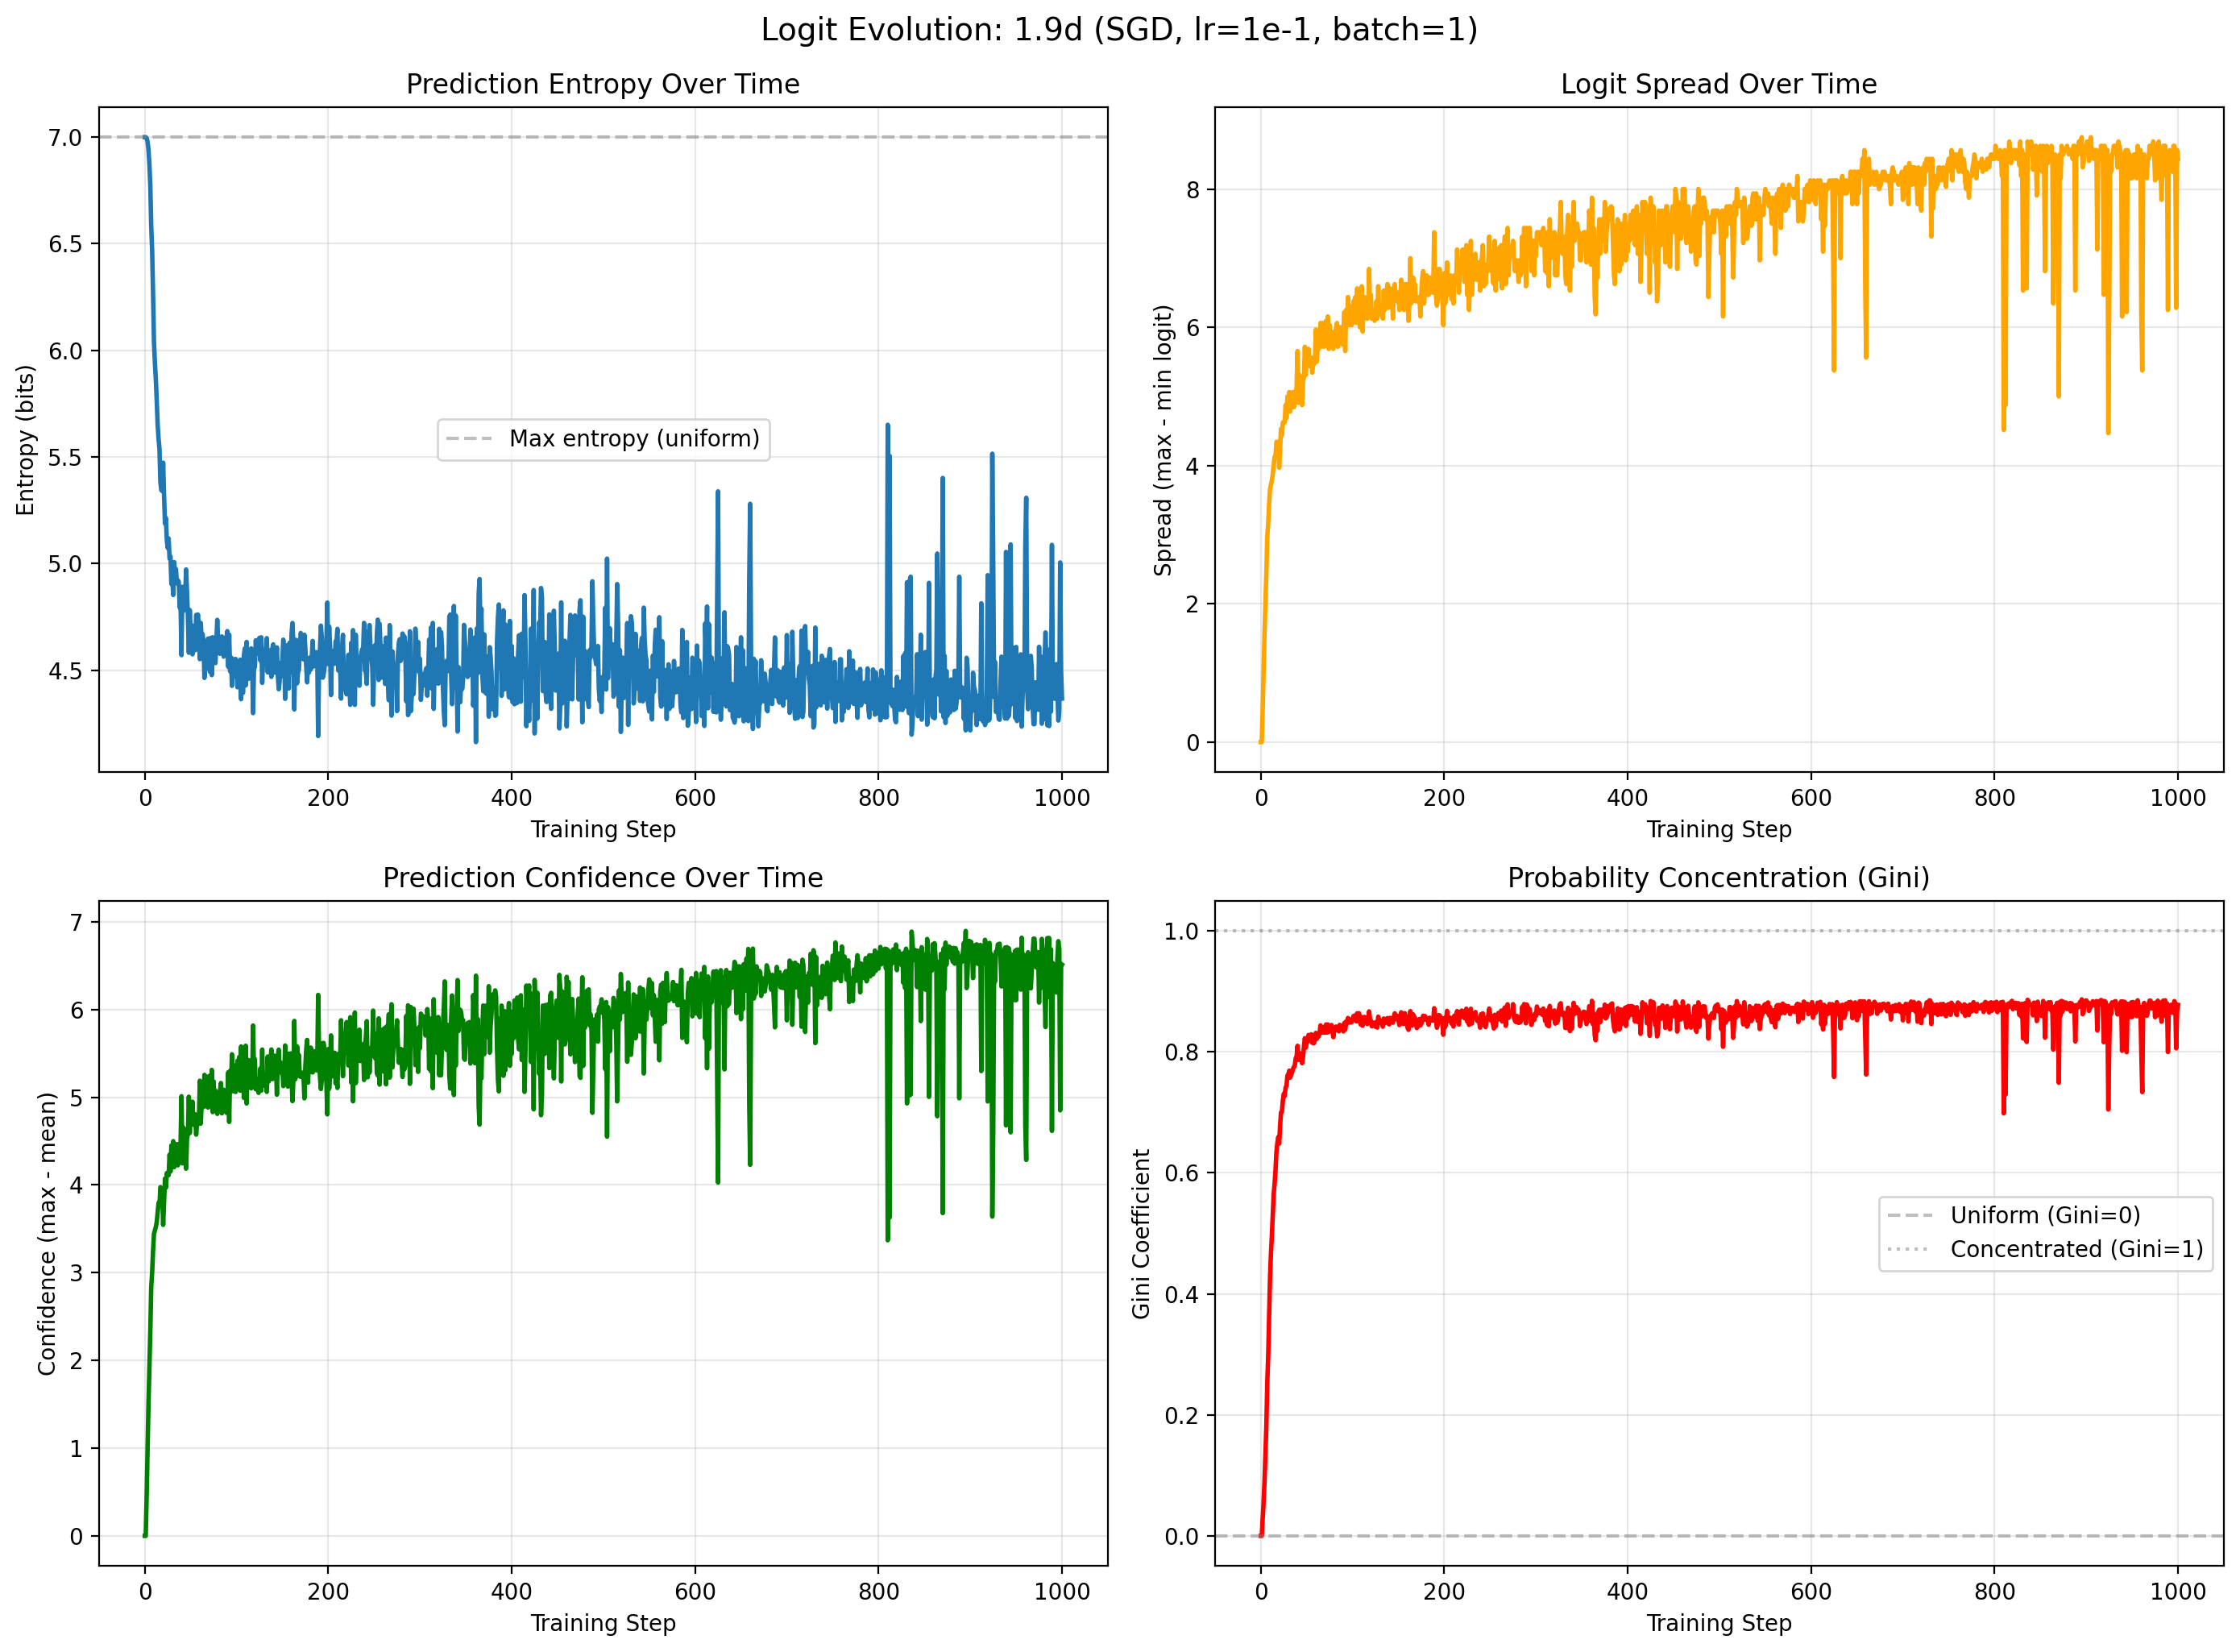

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=DPI)

# Entropy
ax = axes[0, 0]
ax.plot(stats['steps'], stats['entropy'], linewidth=2)
ax.axhline(np.log2(128), color='gray', linestyle='--', alpha=0.5, label='Max entropy (uniform)')
ax.set_xlabel('Training Step')
ax.set_ylabel('Entropy (bits)')
ax.set_title('Prediction Entropy Over Time')
ax.legend()
ax.grid(alpha=0.3)

# Spread
ax = axes[0, 1]
ax.plot(stats['steps'], stats['spread'], linewidth=2, color='orange')
ax.set_xlabel('Training Step')
ax.set_ylabel('Spread (max - min logit)')
ax.set_title('Logit Spread Over Time')
ax.grid(alpha=0.3)

# Confidence
ax = axes[1, 0]
ax.plot(stats['steps'], stats['confidence'], linewidth=2, color='green')
ax.set_xlabel('Training Step')
ax.set_ylabel('Confidence (max - mean)')
ax.set_title('Prediction Confidence Over Time')
ax.grid(alpha=0.3)

# Gini coefficient
ax = axes[1, 1]
ax.plot(stats['steps'], stats['gini'], linewidth=2, color='red')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5, label='Uniform (Gini=0)')
ax.axhline(1, color='gray', linestyle=':', alpha=0.5, label='Concentrated (Gini=1)')
ax.set_xlabel('Training Step')
ax.set_ylabel('Gini Coefficient')
ax.set_title('Probability Concentration (Gini)')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle(f'Logit Evolution: {RUN_NAME}', y=1.02, fontsize=14)
plt.show()

## Top-K Probability Mass

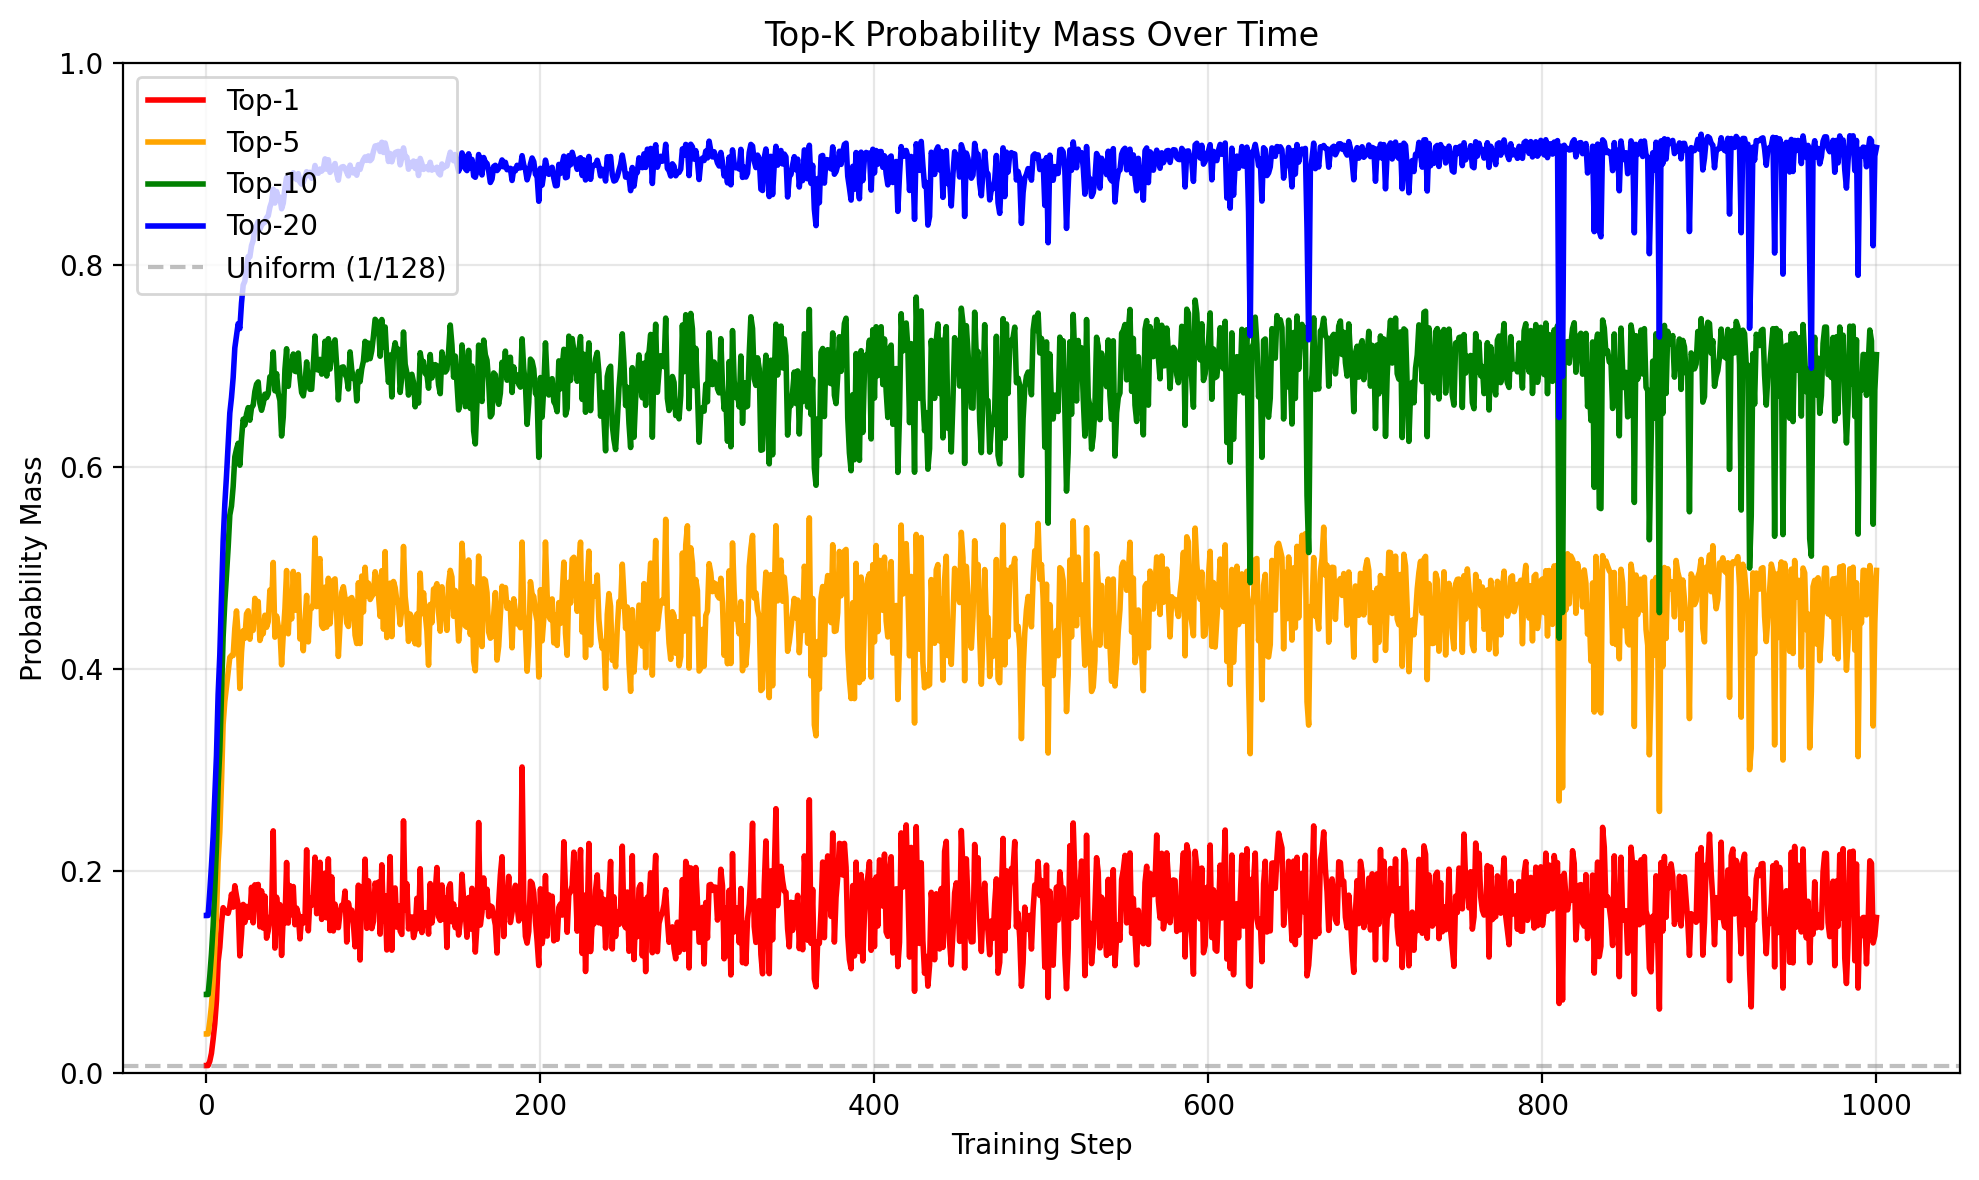

In [43]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

colors = ['red', 'orange', 'green', 'blue']
for i, k in enumerate(TOP_K_VALUES):
    ax.plot(stats['steps'], stats[f'top_{k}_prob'], 
            label=f'Top-{k}', linewidth=2, color=colors[i % len(colors)])

ax.axhline(1/128, color='gray', linestyle='--', alpha=0.5, label='Uniform (1/128)')
ax.set_xlabel('Training Step')
ax.set_ylabel('Probability Mass')
ax.set_title(f'Top-K Probability Mass Over Time')
ax.legend()
ax.grid(alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## Entropy Growth Analysis

ENTROPY GROWTH MODEL FITTING

Models tested: H(t) = a·f(t) + b

Linear (f=t):     residual = 81.567829
Square root (f=√t): residual = 74.084554  ← Jeffery's prediction
Logarithmic (f=log t): residual = 57.382846

Best fit: log (lowest residual)


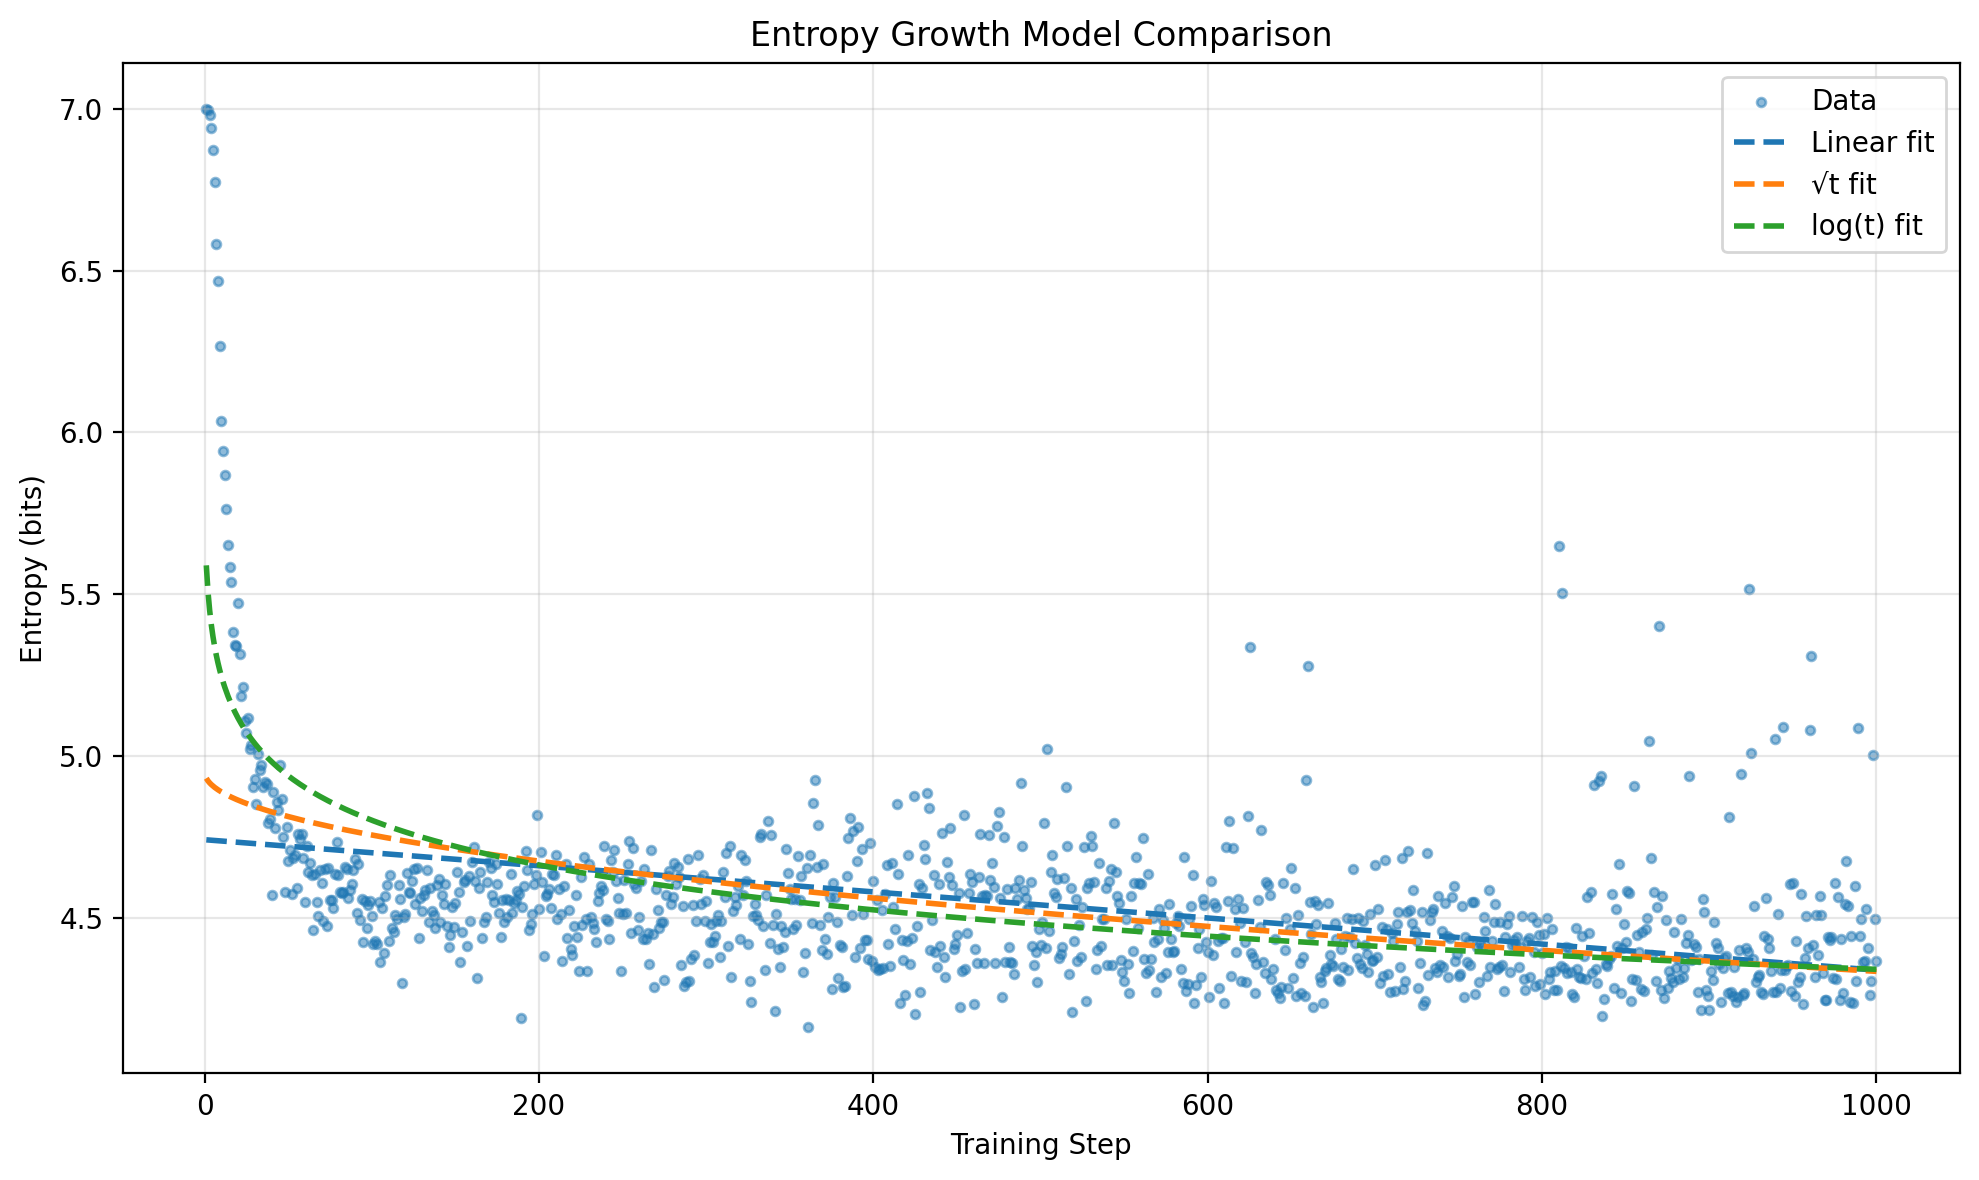

In [44]:
# Test different growth models
from scipy.optimize import curve_fit

# Only fit on steps > 0 where entropy is changing
mask = stats['steps'] > 0
x = stats['steps'][mask]
y = stats['entropy'][mask]

if len(x) > 10 and y.std() > 0.01:  # Only fit if we have data and variation
    # Define models
    def linear(x, a, b):
        return a * x + b
    
    def sqrt_model(x, a, b):
        return a * np.sqrt(x) + b
    
    def log_model(x, a, b):
        return a * np.log(x + 1) + b
    
    # Fit models
    try:
        params_linear, _ = curve_fit(linear, x, y)
        params_sqrt, _ = curve_fit(sqrt_model, x, y)
        params_log, _ = curve_fit(log_model, x, y)
        
        # Compute residuals
        residuals_linear = np.sum((y - linear(x, *params_linear))**2)
        residuals_sqrt = np.sum((y - sqrt_model(x, *params_sqrt))**2)
        residuals_log = np.sum((y - log_model(x, *params_log))**2)
        
        print('='*70)
        print('ENTROPY GROWTH MODEL FITTING')
        print('='*70)
        print()
        print('Models tested: H(t) = a·f(t) + b')
        print()
        print(f'Linear (f=t):     residual = {residuals_linear:.6f}')
        print(f'Square root (f=√t): residual = {residuals_sqrt:.6f}  ← Jeffery\'s prediction')
        print(f'Logarithmic (f=log t): residual = {residuals_log:.6f}')
        print()
        
        best_model = min(
            ('linear', residuals_linear),
            ('sqrt', residuals_sqrt),
            ('log', residuals_log),
            key=lambda x: x[1]
        )
        
        print(f'Best fit: {best_model[0]} (lowest residual)')
        print('='*70)
        
        # Plot
        fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)
        
        ax.scatter(x, y, s=10, alpha=0.5, label='Data')
        ax.plot(x, linear(x, *params_linear), '--', label=f'Linear fit', linewidth=2)
        ax.plot(x, sqrt_model(x, *params_sqrt), '--', label=f'√t fit', linewidth=2)
        ax.plot(x, log_model(x, *params_log), '--', label=f'log(t) fit', linewidth=2)
        
        ax.set_xlabel('Training Step')
        ax.set_ylabel('Entropy (bits)')
        ax.set_title('Entropy Growth Model Comparison')
        ax.legend()
        ax.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except:
        print('Could not fit growth models (possibly insufficient data variation)')
else:
    print('Insufficient data or variation for growth model fitting')

## Logit Distribution Snapshots

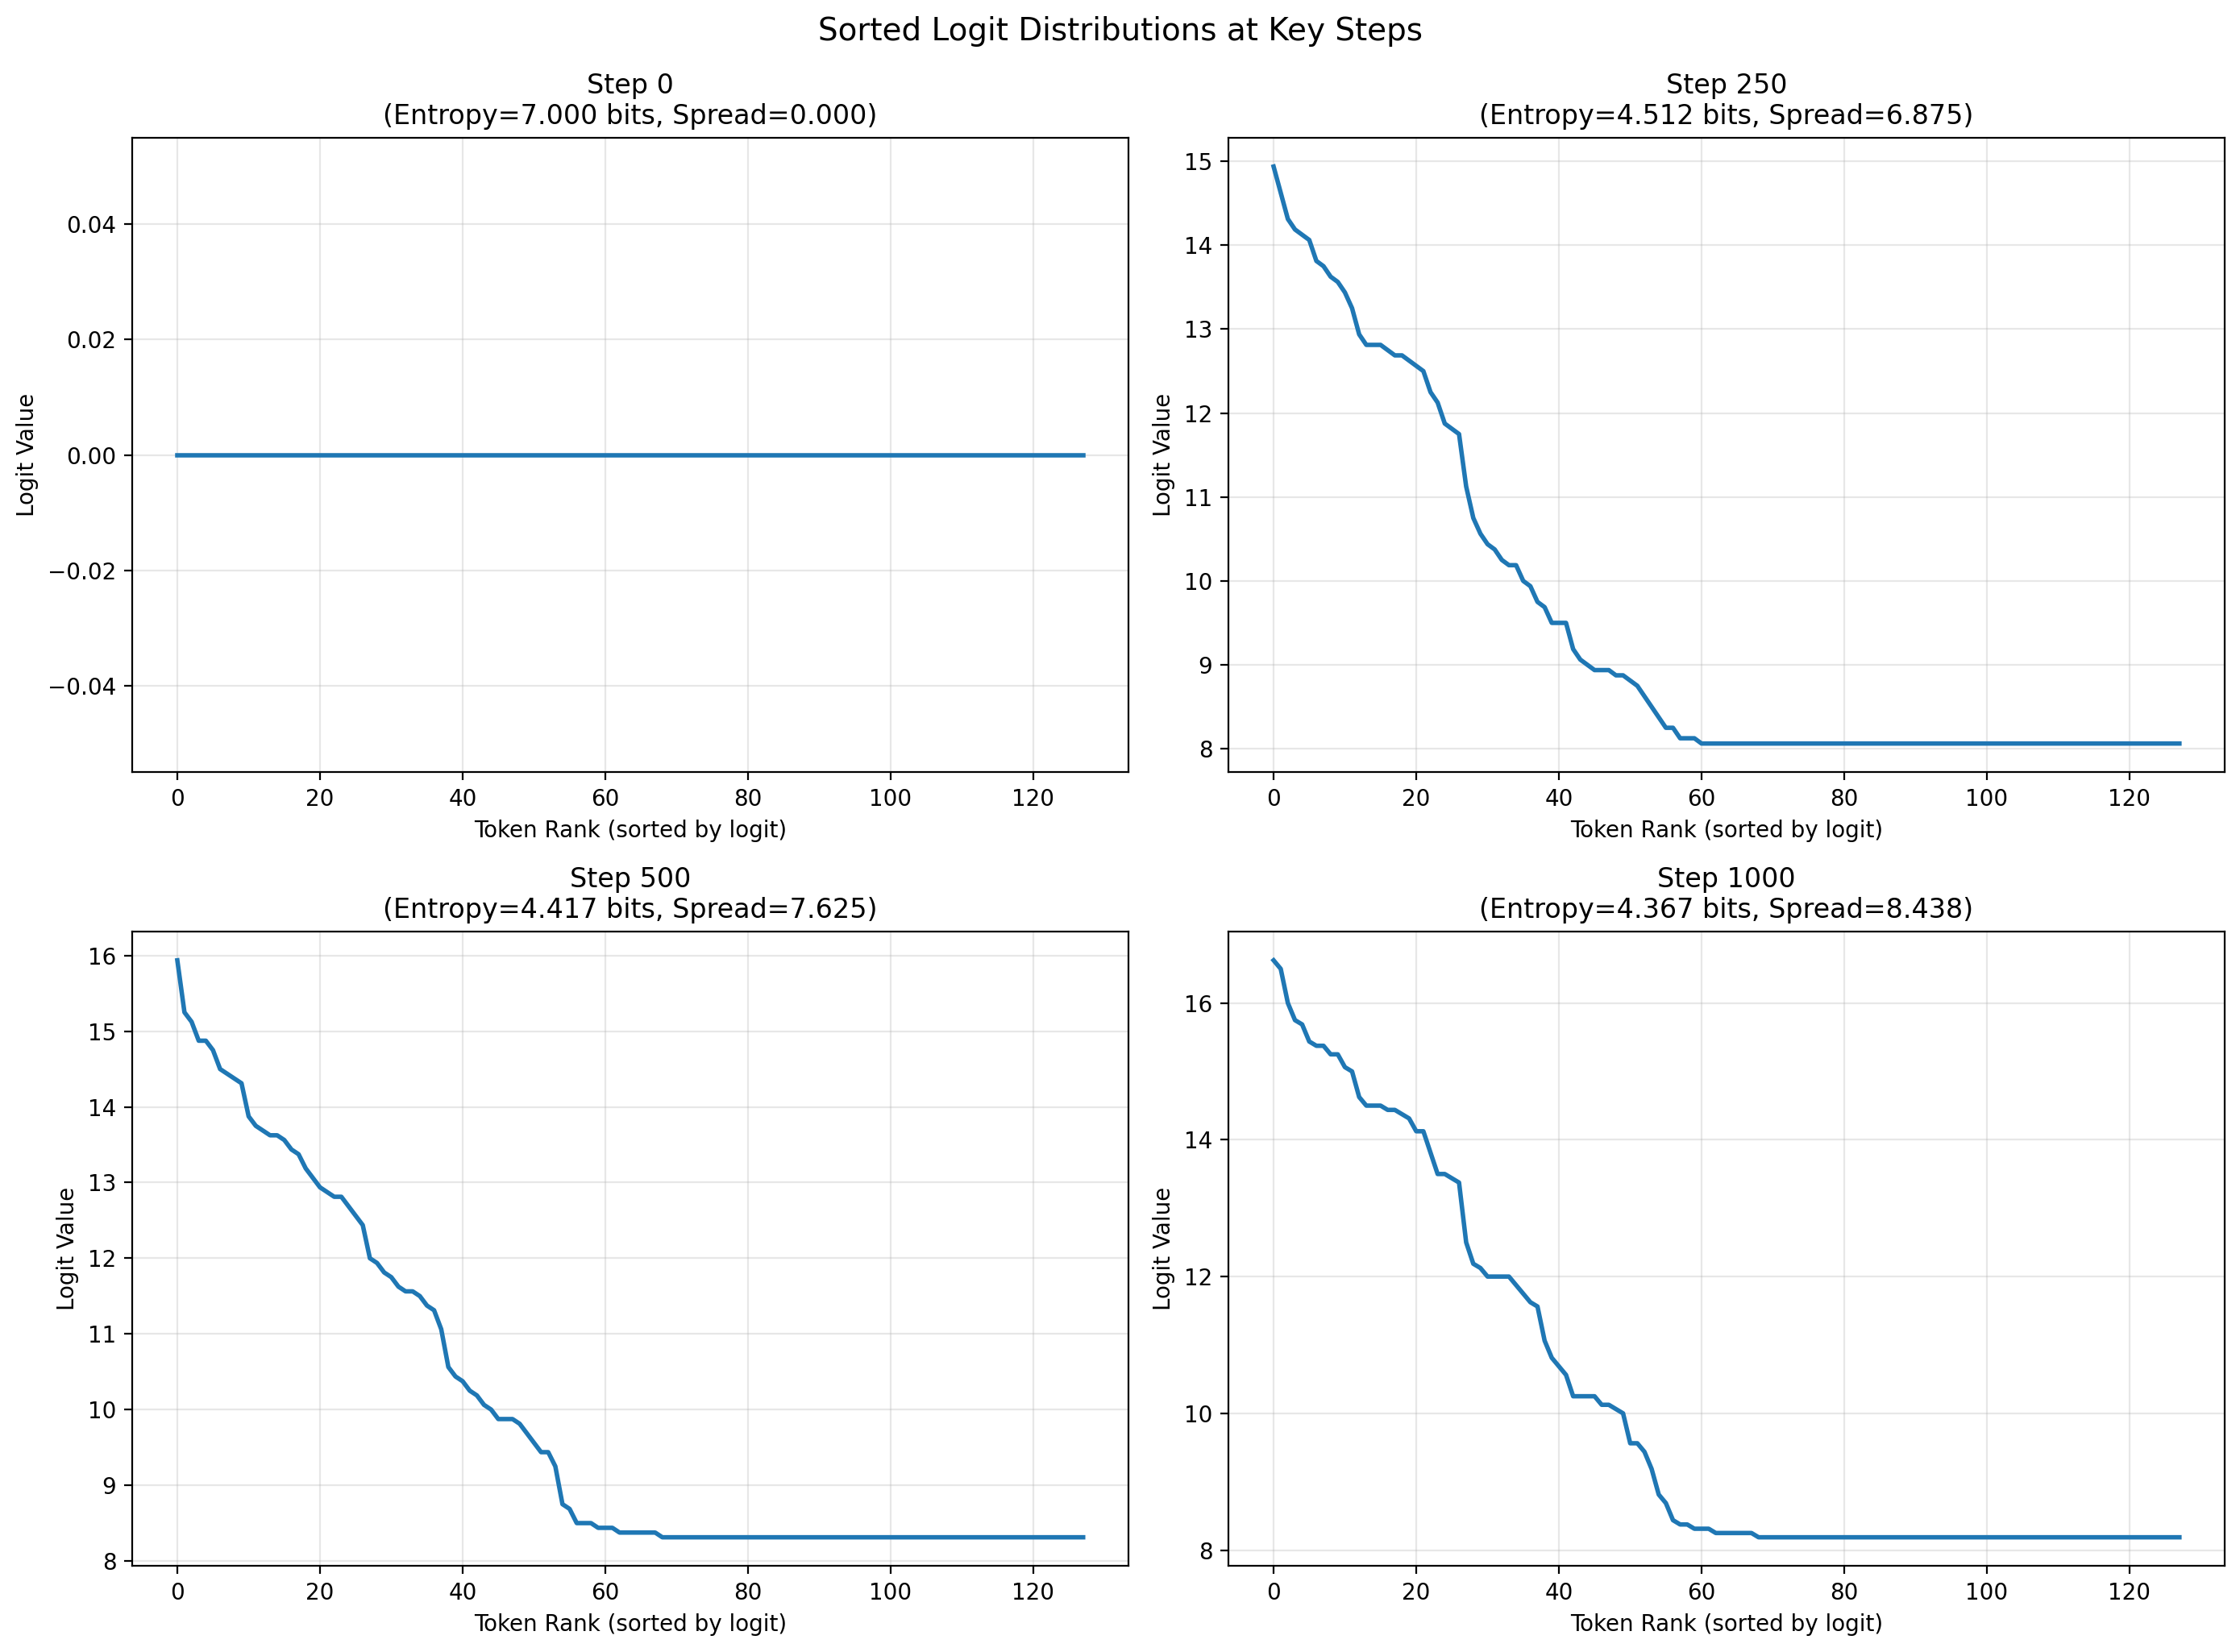

In [45]:
# Show sorted logit distributions at key steps
snapshot_steps = [0, len(step_indices)//4, len(step_indices)//2, len(step_indices)-1]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=DPI)
axes = axes.flatten()

for i, snap_idx in enumerate(snapshot_steps):
    ax = axes[i]
    step = step_indices[snap_idx]
    logit_vec = logits[step]
    
    # Sort descending
    sorted_logits = np.sort(logit_vec)[::-1]
    
    ax.plot(sorted_logits, linewidth=2)
    ax.set_xlabel('Token Rank (sorted by logit)')
    ax.set_ylabel('Logit Value')
    ax.set_title(f'Step {step}\n(Entropy={stats["entropy"][snap_idx]:.3f} bits, Spread={stats["spread"][snap_idx]:.3f})')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('Sorted Logit Distributions at Key Steps', y=1.02, fontsize=14)
plt.show()